In [38]:
%matplotlib inline
import os
import numpy as np
from pcntoolkit.normative_model.norm_utils import norm_init
from pcntoolkit.util.utils import simulate_data
import matplotlib.pyplot as plt
from pcntoolkit.normative import estimate
from warnings import filterwarnings
filterwarnings('ignore')

plt.rcParams.update({'font.size': 8, 'figure.figsize': (5, 3)})


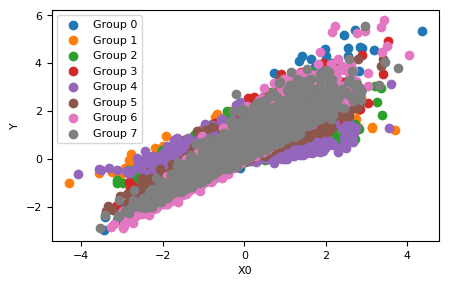

<Figure size 500x300 with 0 Axes>

(16000,)
[[-0.25317189]
 [-0.25317189]
 [-0.25317189]
 ...
 [-0.14649218]
 [-0.14649218]
 [-0.14649218]]


In [44]:
########################### Experiment Settings ###############################
random_state = 29
working_dir = '/home/guus/tmp/'  # Specify a working directory to save data and results.
simulation_method = 'linear'
n_features = 1      # The number of input features of X
n_grps = 8          # Number of batches in data
n_samples = 2000     # Number of samples in each group (use a list for different
# sample numbers across different batches)
model_type = 'bspline'  # modelto try 'linear, ''polynomial', 'bspline'
############################## Data Simulation ################################
X_train, Y_train, grp_id_train, X_test, Y_test, grp_id_test, coef = \
    simulate_data(simulation_method, n_samples, n_features, n_grps,
                  working_dir=working_dir, plot=True, noise='heteroscedastic_nongaussian',
                  random_state=random_state)
plt.tight_layout()
plt.show()
print(Y_train.shape)

random_group_offsets = np.random.normal(0, 1, n_grps)
print(random_group_offsets[grp_id_train])
Y_train += np.squeeze(np.array(random_group_offsets[grp_id_train]))
Y_test += np.squeeze(np.array(random_group_offsets[grp_id_test]))


In [49]:
nm = norm_init(X_train, Y_train, alg='hbr', model_type=model_type, likelihood='SHASHb',
              random_intercept_mu='True', random_slope_mu='False',  linear_sigma='True', linear_delta='True',linear_epsilon='True', nuts_sampler='nutpie')

In [50]:
# Graph is constructed here
nm.estimate(X_train, Y_train, trbefile=working_dir+'trbefile.pkl')

Progress,Draws,Divergences,Step Size,Gradients/Draw
,58,0,0.00,3


In [47]:
yhat, ys2 = nm.predict(X_test, tsbefile=working_dir+'tsbefile.pkl')

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

Sampling: [y_like]


Output()

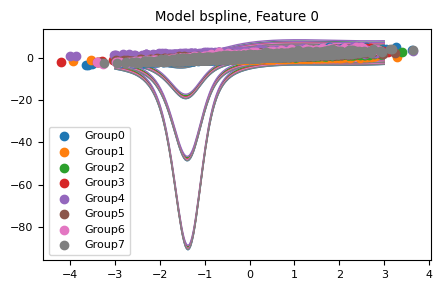

In [48]:

for i in range(n_features):
    sorted_idx = X_test[:, i].argsort(axis=0).squeeze()
    temp_X = X_test[sorted_idx, i]
    temp_Y = Y_test[sorted_idx,]
    temp_be = grp_id_test[sorted_idx, :].squeeze()
    temp_yhat = yhat[sorted_idx,]
    temp_s2 = ys2[sorted_idx,]

    plt.figure()
    for j in range(n_grps):
        scat1 = plt.scatter(temp_X[temp_be == j,], temp_Y[temp_be == j,],
                            label='Group' + str(j))
        # Showing the quantiles
        resolution = 200
        synth_X = np.linspace(-3, 3, resolution)
        q = nm.get_mcmc_quantiles(
            synth_X, batch_effects=j*np.ones(resolution))
        col = scat1.get_facecolors()[0]
        plt.plot(synth_X, q.T,  linewidth=1, color=col, zorder=0)

    plt.title('Model %s, Feature %d' % (model_type, i))
    plt.legend()
    plt.show()